<a href="https://colab.research.google.com/github/jdluebbe/Clean-U-net-code/blob/master/Cleaned_DataLoader_+_Random_Sampler_with_Unet_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install scikit-image --upgrade
!pip install imageio
!pip install torch
!pip install torchvision
!pip install tifffile

!pip install albumentations
!pip install opencv-python



!pip install scikit-image --upgrade

#https://stackoverflow.com/questions/53237161/error-in-google-colaboratory-attributeerror-module-pil-image-has-no-attribu
!pip install Pillow==5.3.0

Requirement already up-to-date: scikit-image in /usr/local/lib/python3.6/dist-packages (0.14.1)
Requirement already up-to-date: scikit-image in /usr/local/lib/python3.6/dist-packages (0.14.1)


## Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
path = "./gdrive/My Drive/ISBI-NeuronalStackElectronMicroscopy/"
os.listdir(path)

['train-volume.tif', 'train-labels.tif', 'test-volume.tif']

## Dataset

In [0]:
import tifffile as tiff
from torch.utils.data.dataset import Dataset
from PIL import Image


from torchvision import transforms, datasets, models


class SegmentationDataset(Dataset):
    """ Dataset loader to pass to the pytorch DataSet
    Arguments:
          train_filename :
          labels_filename:
          transform:
    Returns:
        a list of train_images, train_labels 4D tensor tuples

    """

    def __init__(self,
                 train_filename,
                 labels_filename,
                 transform=None,
                 augmentations=None):

        self.train_filename = train_filename
        self.labels_filename = labels_filename
        self.transform = transform
        self.augmentations = augmentations
        self.len_train = tiff.imread(self.train_filename).shape[0]

    def __len__(self):
        return self.len_train
    
    #these methods should not be used directly
    def _get_train(self, index):
        return Image.fromarray((tiff.imread(self.train_filename))[index])

    def _get_label(self, index):
        return Image.fromarray((tiff.imread(self.labels_filename))[index])

    def __getitem__(self, index):
      
        
        trainLoad = self._get_train(index) 
        labelLoad = self._get_label(index)
        
        # is not is used as None is an object
        if self.augmentations is not None:
          trainArray = np.array(trainLoad)
          labelArray = np.array(labelLoad)
          augImages = self.augmentations(image=trainArray, 
                                         mask=labelArray)
          
          trainLoad  = Image.fromarray(augImages["image"])
          labelLoad  = Image.fromarray(augImages["mask"])
        
        train_images = self.transform(trainLoad)  
        train_labels = self.transform(labelLoad)

        
        
        return [train_images, train_labels]
      




In [0]:
transform = transforms.Compose([
    transforms.Resize(64, interpolation = 2), # this is a list of PIL Images
    transforms.ToTensor() # returns a 4D tensor
])


dataset = SegmentationDataset(path+'train-volume.tif',
                              path+'train-labels.tif',
                              transform, 
                              None)



# Train-validation split

In [0]:
# we start splitting randomly the train and validation sets

import numpy as np
indices = np.array(range(0, 30))
np.random.seed(42)
# 70% of the data goes into the training set
trainSetIndices = np.random.choice(indices.shape[0], int(indices.shape[0] * .7), replace=False)
trainSetIndices

array([27, 15, 23, 17,  8,  9, 28, 24, 12,  0,  4, 16,  5, 13, 11, 22,  1,
        2, 25,  3, 21])

In [0]:
# the difference between the training set and the rest of indices is the test set
testSetIndices = np.setdiff1d(indices, trainSetIndices)
testSetIndices

array([ 6,  7, 10, 14, 18, 19, 20, 26, 29])

In [0]:
import torch

from torch.utils.data.sampler import RandomSampler

train_sampler = RandomSampler(trainSetIndices)

iterTrainSampler = iter(train_sampler)

trainSample = next(iterTrainSampler)

trainSample

13

In [0]:
len(train_sampler)

NameError: ignored

In [0]:
#where do we put train_sampler?

dataloader = torch.utils.data.DataLoader(dataset, 
                                         batch_size = 2, 
                                         sampler = train_sampler)
dataloader

In [0]:
# prints the number of batches created by the dataloader
len(dataloader)

11

## Unet class

In [0]:
# Adapted from https://discuss.pytorch.org/t/unet-implementation/426

import torch
from torch import nn
import torch.nn.functional as F


class UNet(nn.Module):
    def __init__(self, in_channels=1, n_classes=2, depth=5, wf=6, padding=False,
                 batch_norm=False, up_mode='upconv'):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597

        Using the default arguments will yield the exact version used
        in the original paper

        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(UNetConvBlock(prev_channels, 2**(wf+i),
                                                padding, batch_norm))
            prev_channels = 2**(wf+i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(UNetUpBlock(prev_channels, 2**(wf+i), up_mode,
                                            padding, batch_norm))
            prev_channels = 2**(wf+i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path)-1:
                blocks.append(x)               
                x = F.avg_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i-1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3,
                               padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3,
                               padding=int(padding)))
        block.append(nn.ReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2,
                                         stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(nn.Upsample(mode='bilinear', scale_factor=2),
                                    nn.Conv2d(in_size, out_size, kernel_size=1))

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[:, :, diff_y:(diff_y + target_size[0]), diff_x:(diff_x + target_size[1])]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out


## Pass to the Dataloader a Dataset with augmentations

### Write the Dice similarity coefficient function

## Augmentations 

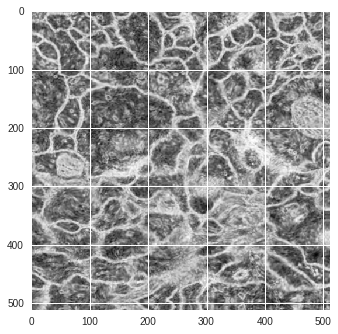

In [0]:
import numpy as np
from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomContrast,
    RandomGamma,
    RandomBrightness
)

datasetNoAug = SegmentationDataset(path+'train-volume.tif',
                               path+'train-labels.tif',
                                None, None)

datasetNoAug._get_train(0)

padAug = PadIfNeeded(p=1, min_height=128, min_width=128)

elasticAug = ElasticTransform(p=1, alpha=120, sigma=10, alpha_affine=120 * 0.3)

transform = transforms.Compose([
    transforms.Resize(512, interpolation = 2), # this is a list of PIL Images
    transforms.ToTensor() # returns a 4D tensor
])

datasetAug = SegmentationDataset(path+'train-volume.tif',
                                 path+'train-labels.tif',
                                 transform, elasticAug)

#we want to create images from these tensors to check the augmentations
datasetAug[0]

#1 - convert to numpy array
np.array(datasetAug[0][0]).shape

augTestArray1 = np.array(datasetAug[0][0][0])

# call Image.fromarray(
plt.imshow(np.array(datasetAug[0][0][0]))




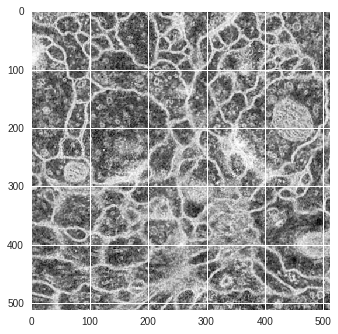

In [0]:
import numpy as np
from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomContrast,
    RandomGamma,
    RandomBrightness
)

datasetNoAug = SegmentationDataset(path+'train-volume.tif',
                               path+'train-labels.tif',
                                None, None)

datasetNoAug._get_train(0)

padAug = PadIfNeeded(p=1, min_height=128, min_width=128)

elasticAug = ElasticTransform(p=1, alpha=120, sigma=10, alpha_affine=120 * 0.3)

transform = transforms.Compose([
    transforms.Resize(512, interpolation = 2), # this is a list of PIL Images
    transforms.ToTensor() # returns a 4D tensor
])

datasetAug = SegmentationDataset(path+'train-volume.tif',
                                 path+'train-labels.tif',
                                 transform, None)

#we want to create images from these tensors to check the augmentations
datasetAug[0]

#1 - convert to numpy array
np.array(datasetAug[0][0]).shape

augTestArray1 = np.array(datasetAug[0][0][0])

# call Image.fromarray(
plt.imshow(np.array(datasetAug[0][0][0]))




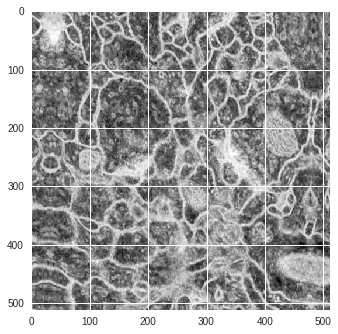

In [0]:
datasetAug = SegmentationDataset(path+'train-volume.tif',
                                 path+'train-labels.tif',
                                 transform, elasticAug)

#we want to create images from these tensors to check the augmentations
datasetAug[0]

#1 - convert to numpy array
np.array(datasetAug[0][0]).shape

# call Image.fromarray(
plt.imshow(np.array(datasetAug[0][0][0]))

In [0]:
import numpy as np
from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomContrast,
    RandomGamma,
    RandomBrightness
)

dataset = SegmentationDataset(path+'train-volume.tif',
                               path+'train-labels.tif',
                                None)

dataset._get_train(0)


aug = ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)


augs =  aug(image = np.array(dataset._get_train(0)), mask = np.array(dataset.get_label(0)))

plt.imshow(augs['image'])


AttributeError: ignored

In [0]:
aug = PadIfNeeded(p=1, min_height=128, min_width=128)


In [0]:
# https://stackoverflow.com/questions/10965417/how-to-convert-numpy-array-to-pil-image-applying-matplotlib-colormap

In [0]:
import tifffile as tiff
from torch.utils.data.dataset import Dataset
from PIL import Image


from torchvision import transforms, datasets, models


class SegmentationDataset(Dataset):
    """ Dataset loader to pass to the pytorch DataSet
    Arguments:
          train_filename :
          labels_filename:
          transform:
    Returns:
        a list of train_images, train_labels 4D tensor tuples

    """

    def __init__(self,
                 train_filename,
                 labels_filename,
                 transform=None):

        self.train_filename = train_filename
        self.labels_filename = labels_filename
        self.transform = transform
        self.len_train = tiff.imread(self.train_filename).shape[0]

    def __len__(self):
        return self.len_train

    def _get_train(self, index):
        return Image.fromarray((tiff.imread(self.train_filename))[index])

    def _get_label(self, index):
        return Image.fromarray((tiff.imread(self.labels_filename))[index])

    def __getitem__(self, index):
      
        
        trainLoad = self._get_train(index) 
        labelLoad = self._get_label(index)
        
        train_images = self.transform(trainLoad)  
        train_labels = self.transform(labelLoad)

        return [train_images, train_labels]




## Training loop



In [0]:
import torch
import torch.nn.functional as F


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# n_classes -> number of classes that we want to predict in the image
model = UNet(n_classes=1, depth = 2, padding=True, up_mode='upsample').to(device)
optim = torch.optim.Adam(model.parameters())


### adding the missing dataloader##

dataset = SegmentationDataset(path+'train-volume.tif',
                               path+'train-labels.tif',
                                transform, None)


dataloader = torch.utils.data.DataLoader(dataset, 2)

epochs = 10


# needs to be specified before the loop as it is a module
# we need to create it to use it
loss_bce = nn.BCEWithLogitsLoss()

for _ in range(epochs):
  for X, y in dataloader:
    X = X.to(device)  # [N, 1, H, W]
    y = y.to(device)  # [N, H, W] with class indices (0, 1)
    prediction = model(X)  # [N, 2, H, W]
    lossValue = loss_bce(prediction, y)
    print(lossValue)
    optim.zero_grad()
    lossValue.backward()
    optim.step()
        
       

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


tensor(0.7287, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.7021, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.6721, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.6126, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5447, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.6505, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5663, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4940, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5257, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5309, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5294, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5186, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4968, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5109, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.4743, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5525, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5870, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.5924, device='cuda:0',

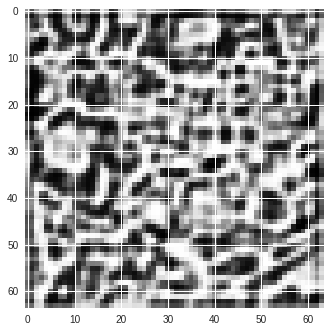

In [0]:
import matplotlib.pyplot as plt

# we have to pass sigmoid because the network doesn't have it 

# detach() detaches the gradient, it protects the variable (PyTorch technicality)

plt.imshow(prediction[0].sigmoid().cpu().detach().numpy()[0])



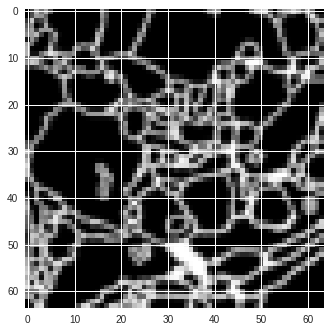

In [0]:
plt.imshow(y[0].cpu().detach().numpy()[0])


In [0]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
 
# use the plot function
plt.plot(lossValues)

##Evaluate the test images

In [0]:
#prediction = model(X)  # [N, 2, H, W]

# This activates the inference state on the network
model.eval()

In [0]:
results = []
for X, y in dataloader2:
  X = X.to(device)  # [N, 1, H, W]
  results = model(X)
  
results

##Augmentations

In [0]:
import numpy as np
from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomContrast,
    RandomGamma,
    RandomBrightness
)

datasetNoAug = SegmentationDataset(path+'train-volume.tif',
                               path+'train-labels.tif',
                                None, None)

datasetNoAug._get_train(0)

padAug = PadIfNeeded(p=1, min_height=128, min_width=128)

elasticAug = ElasticTransform(p=1, alpha=120, sigma=10, alpha_affine=120 * 0.3)

transform = transforms.Compose([
    transforms.Resize(512, interpolation = 2), # this is a list of PIL Images
    transforms.ToTensor() # returns a 4D tensor
])

datasetAug = SegmentationDataset(path+'train-volume.tif',
                                 path+'train-labels.tif',
                                 transform, elasticAug)

#we want to create images from these tensors to check the augmentations
datasetAug[0]

#1 - convert to numpy array
np.array(datasetAug[0][0]).shape

augTestArray1 = np.array(datasetAug[0][0][0])

# call Image.fromarray(
plt.imshow(np.array(datasetAug[0][0][0]))


In [0]:
# this dataset applies the augmentations randomly 
# train-volume.tif should be renamed to volume.tif
# train-labels.tif should be renamed to labels.tif 
# as we are using both as train and test set  
datasetAug = SegmentationDataset(path+'train-volume.tif',
                                 path+'train-labels.tif',
                                 transform, elasticAug)

datasetNoAug = SegmentationDataset(path+'train-volume.tif',
                                   path+'train-labels.tif',
                                   transform, None)

#we want to create images from these tensors to check the augmentations
datasetAug[0]

#1 - convert to numpy array
np.array(datasetAug[0][0]).shape

# call Image.fromarray(
plt.imshow(np.array(datasetAug[0][0][0]))

In [0]:
datasetAug._get_train(0)